<a href="https://colab.research.google.com/github/ZainShaikh-12/AIAgents/blob/main/LangGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup your API-Keys

In [ ]:
from google.colab import userdata

In [ ]:
LANGCHAIN_API_KEY = userdata.get('LANGCHAIN_API_KEY')
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
TAVILY_API_KEY = userdata.get('TAVILY_API_KEY')
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

In [ ]:
import os
os.environ['LANGCHAIN_API_KEY'] = LANGCHAIN_API_KEY
os.environ['lANGCHAIN_TRACING_V@'] = 'true'
os.environ['LANGCHAIN_PROJECT'] = "Langgraph_Tutorial"
os.environ['GOOGLE_API_KEY'] = GOOGLE_API_KEY


Install requried packages

In [ ]:

%pip install --quiet -U langgraph langchain-google-genai langchain_core -U langsmith


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.2/292.2 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.0/378.0 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.7 MB/s eta 0:00:00


# State
the first thing you do when you define a graph is define the state of graph.The State schema serves as the input schema for all nodes and Edges in the graph.This example uses a simple dictionary structure with a single key "graph_state" of type str

In [ ]:
from typing import TypedDict

class State(TypedDict):
    graph_state: str

# Nodes
Nodes are just python functions.
The first positional argument is the state, as defined above.
Each node operates on the state.
By default, each node will also override the prior state value

In [ ]:
def node_1(state):
  print("Node 1")
  return {"graph_state": state["graph_state"] + "I am"}

def node_2(state):
  print("Node 2")
  return {"graph_state": state["graph_state"] + " Happy"}

def node_3(state):
  print("Node 3")
  return {"graph_state": state["graph_state"] + " Sad"}

# Edges
Edges simply connect the nodes.
Normal Edges are used if you want to always go from, for example node_1 to node_2.
Conditional Edges are used want to optionally route-between nodes.
The conditional edge is implemented as a function that returns the next node to visit base upon some logic

In [ ]:
import random
from typing import Literal

def decide_mood(state) -> Literal["node_2", "node_3"]:

  # Often, we will use state to decide on the next node to visit
  user_input = state['graph_state']

  # Here, let's just do a 50/50 split between nodes 2, 3
  if random.random() < 0.5:

    #50% of the time, we return Node 2
    return "node_2"
  #50% of the time, we return Node 3
  return "node_3"

# Graph Construction

Now, we build the graph from our components!
* The (StateGraph) class is the main graph class to use which is imported from langgraph.graph.
First, we initialize a (StateGraph) with the (State) class we defined above.
Then, we add our nodes and edges.
* We use the (Start) Node, a special node that sends user input to the graph, to indicate where to start our graph.
* The (End) Node is a special node that represents a terminal node.
Compile our graph to perform a few basic checks about the structure of your graph (no orphand nodes, etc)

In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

#Build graph

builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

#Logic

builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

graph = builder.compile()


In [ ]:
graph.invoke({"graph_state": "Hi, this is Shaikh."})

Node 1
Node 2


{'graph_state': 'Hi, this is Shaikh.I am Happy'}

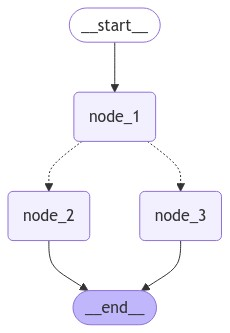

In [ ]:
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

# Chain
We built a simple graph with nodes, normal edges, and conditional edges

# Goals
Now let's build up to a simple chain that combines 4 key concepts:
* Using chat messages in our graph
* using chat models
* binding tools to our LLM
* Executing tool calls in our graph

# Messages
Chat models can use messages, which capture different roles within a conversation.
Langchain supports various message types, including HumanMEssage, AIMessage, SystemMessage, and ToolMessage.
These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call.


Let's create a list of messages. Each message can be supplied with a few things:

* content-content of the message
* name-optionally, who is creating the message
* response_metadata-optionally,a dict of metadata that is often specific to each model provider

In [ ]:
from pprint import pprint
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage


messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-pro", api_key=GEMINI_API_KEY)
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

# Tools
Tools are needed whenever you want a model to control parts of your code or call out external APIs.Many LLM providers support tool calling.The tool calling interface in langchain is simple.
you can pass any Python function into ChatModel.bind_tools()

In [ ]:
def multiply(a: int, b:int ) -> int:
  """Multiply a and b

  Args:
     a: first int
     b: second int
  """
  return a * b

llm_with_tools = llm.bind_tools([multiply])

In [ ]:

tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])
tool_call

AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"b": 3.0, "a": 2.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-ee328273-2795-4766-90b5-0679d00df671-0', tool_calls=[{'name': 'multiply', 'args': {'b': 3.0, 'a': 2.0}, 'id': 'b33da22a-37f8-4e29-b71f-ff04c1d32741', 'type': 'tool_call'}], usage_metadata={'input_tokens': 70, 'output_tokens': 18, 'total_tokens': 88})

In [ ]:
tool_call.additional_kwargs['function_call']


{'name': 'multiply', 'arguments': '{"b": 3.0, "a": 2.0}'}

# Using messages as state

when these foundations in place, we can now use messages in our graph state.
Let's define our state MEssagesState.
its defined as a TypedDict with a single key: messages.
messages is simply a list of type AnyMessage.meaning its a list of messages

In [ ]:

from typing_extensions import TypedDict
from typing import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [ ]:
initial_messages = [AIMessage(content=f"How can i assist you today?", name="sarah"),
                   HumanMessage(content=f"I want to learn Langgraph.", name="Shaikh")
                   ]

new_messages = AIMessage(content="Sure i can help with that where do you want to start?", name="sarah")

add_messages(initial_messages, new_messages)


[AIMessage(content='How can i assist you today?', additional_kwargs={}, response_metadata={}, name='sarah', id='bbbd5ed7-9151-473a-9fea-172a41a03e26'),
 HumanMessage(content='I want to learn Langgraph.', additional_kwargs={}, response_metadata={}, name='Shaikh', id='649e718a-d35c-4ad8-b983-351748d3896d'),
 AIMessage(content='Sure i can help with that where do you want to start?', additional_kwargs={}, response_metadata={}, name='sarah', id='705d6978-2adb-455d-9233-7ce37f6111aa')]

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import AnyMessage,add_messages

In [ ]:
class State(TypedDict):
  # Messages have the type "list". The 'add_messages' function
  # in the annotation defines how this state key should be updated
  # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list[AnyMessage], add_messages]

Build a chatbot by adding nodes and defing

In [ ]:
graph_builder = StateGraph(State)

def ChatBot(state):
  return {'messages': llm.invoke(state['messages'])}

graph_builder.add_node("ChatBot", ChatBot)
graph_builder.add_edge(START, "ChatBot")
graph_builder.add_edge("ChatBot", END)

graph = graph_builder.compile()
# graph.invoke({'messages': 'my name is zain shaikh'})

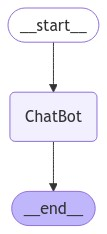

In [ ]:
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
while True:
  user_input=input("User: ")
  if user_input.lower() in ["exit" , "quit"]:
    print("goodBye")
    break
  for event in graph.stream({'messages':("user", user_input)}):
    # print(event.values())
    for value in event.values():
    #  print(value['messages'])
     print("Assistant:",value['messages'].content)



User: what is device
Assistant: The term "device" is incredibly broad and can refer to many different things depending on the context.  To help me give you a more specific answer, could you please tell me:

* **What kind of device are you interested in?** For example, are you thinking about:
    * **Electronic devices:** like smartphones, computers, TVs, etc.
    * **Mechanical devices:** like cars, bicycles, tools, etc.
    * **Medical devices:** like pacemakers, hearing aids, etc.
    * **Something else entirely?** 

Once I know what kind of device you're interested in, I can give you a more relevant and helpful answer. 

User: never mind
Assistant: No problem! Is there anything else I can help you with? 

User: no exit
Assistant: "No Exit" is a play by Jean-Paul Sartre, a prominent figure in existentialist philosophy. It's a short, intense work that explores themes of isolation, existential angst, and the nature of hell. 

Here's a breakdown of the play's key elements:

**Setting:**

In [ ]:
%pip install -q -U langchain_community wikipedia Arxiv


  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.9 MB/s eta 0:00:00


In [ ]:
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper
from langchain_community.tools import WikipediaQueryRun, ArxivQueryRun

WikipediaWrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=300)
ArxivWrapper = ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=300)

wikipedia_tool = WikipediaQueryRun(api_wrapper=WikipediaWrapper)
arxiv_tool = ArxivQueryRun(api_wrapper=ArxivWrapper)

In [ ]:
wikipedia_tool.invoke("what is ak 47")

'Page: AK-47 (cannabis)\nSummary: AK-47, also known simply as AK, is a cannabis strain with high THC content. It is a hybrid strain of cannabis that is sativa-dominant; it mixes Colombian, Mexican, Thai, and Afghan strains. A strong and popular strain, it has won multiple cannabis industry awards. The'

In [ ]:
tools=[wikipedia_tool,arxiv_tool]

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list, add_messages]


In [ ]:
llm_with_tools = llm.bind_tools(tools=tools)

In [ ]:
#Nodes

def RAGBot(state: MessagesState):
  return {'messages': llm_with_tools.invoke(state['messages'])}

# def Tool(state: MessagesState):
#   return {'messages': tools.invoke(state['messages'])}

In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode,tools_condition

graph_builder = StateGraph(MessagesState)
toolNode = ToolNode(tools=tools)

graph_builder.add_node("RAGBot", RAGBot)
graph_builder.add_node("tools", toolNode)

graph_builder.add_edge(START, "RAGBot")
graph_builder.add_conditional_edges(
    "RAGBot",
    tools_condition

)
graph_builder.add_edge("tools","RAGBot")
graph_builder.add_edge("RAGBot", END)

graph = graph_builder.compile()

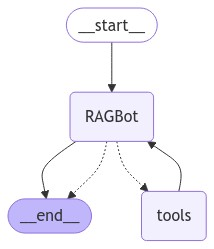

In [ ]:
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
user_input ="Hi there!, who is Shahrukhkhan"

events = graph.stream(
    {'messages':[("user", user_input)]},stream_mode="values"
    )

for event in events:
  event['messages'][-1].pretty_print()

================================ Human Message =================================

Hi there!, who is Shahrukhkhan
================================== Ai Message ==================================
Tool Calls:
  wikipedia (f42d48b8-3d3b-404b-8792-ad45f6835ac8)
 Call ID: f42d48b8-3d3b-404b-8792-ad45f6835ac8
  Args:
    query: Shahrukhkhan
================================= Tool Message =================================
Name: wikipedia

Page: Shah Rukh Khan
Summary: Shah Rukh Khan (pronounced [ˈʃɑːɦɾʊx xɑːn] ; born 2 November 1965), also known by the initialism SRK, is an Indian actor and film producer who works in Hindi cinema. Referred to in the media as the "Baadshah of Bollywood" and "King Khan", he has appeared in more than 10
================================== Ai Message ==================================

Shahrukh Khan is an Indian actor and film producer who works in Hindi cinema. Referred to in the media as the "Baadshah of Bollywood" and "King Khan", he has appeared in more than 100